Import libraries



In [29]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset,Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Set seed

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
train_dataset = datasets.CIFAR10(root = 'dataset/',train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = 'dataset/',train = False, download = True, transform = transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [35]:
def create_subset(dataset:torch.utils.data.Dataset ,classes: list,n_eachclass: int) -> list:
  '''
  Determine indexes of samples that belongs to each desired class
  return indexes of samples
  
  '''
  class_count = {cls : 0 for cls in classes }

  subset_indexes = []
  for i in range(len(dataset)):
    x, y = dataset[i]
    if (y in classes) and (y in class_count.keys()) and (class_count[y] < n_eachclass):
      subset_indexes.append(i)
      class_count[y] = class_count[y] + 1
  
  return subset_indexes


In [6]:
first_subset_idx = create_subset(train_dataset,[0,1,2,3,4],100)

In [7]:
second_subset_idx = create_subset(train_dataset,[5,6,7,8,9],100)

In [8]:
first_subset = Subset(dataset=train_dataset,indices=first_subset_idx)
second_subset = Subset(dataset=train_dataset,indices=second_subset_idx)

In [31]:
class CustomDataset(Dataset):
  """
  Implementing custom dataset to select random pair and compute the mean of them
  
  """
  def __init__(self,first_dataset,second_dataset):
    super(CustomDataset,self).__init__()
    self.first = first_dataset
    self.second = second_dataset

  def __len__(self):
    return len(self.first) + len(self.second)

  def __getitem__(self,idx):
    rand_1 = np.random.randint(len(self.first))
    rand_2 = np.random.randint(len(self.second))

    x_1,_ = self.first[rand_1]
    x_2,_ = self.second[rand_2]

    mean_x = (x_1 + x_2)/2

    return x_1, x_2, mean_x

In [16]:
custom_dataset = CustomDataset(first_subset,second_subset)
custom_loader = DataLoader(dataset = custom_dataset,batch_size = 32,shuffle = True,pin_memory=True)

# VAE

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, 3, stride=2, )
        self.batch1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 128, 3, stride=2, )
        self.batch2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, 3, stride=2, )
        self.batch3 = nn.BatchNorm2d(64)
        self.linear1 = nn.Linear(3*3*64, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

    def reparameterize(self, mu, logVar):

        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):

        x = F.relu(self.batch1(self.conv1(x)))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.batch3(self.conv3(x)))
        
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))

        mu =  self.linear2(x)
        logVar = self.linear3(x)

        z = self.reparameterize(mu, logVar)
        
        return mu, logVar,z      

In [32]:
class VAEDecoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.latent_space = nn.Sequential(
            nn.Linear(latent_dims, 128),
            # nn.BatchNorm1d(128,),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 64),
            # nn.BatchNorm1d(3 * 3 * 64),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(64, 3, 3))

        self.decoder= nn.Sequential(
            nn.ConvTranspose2d(64, 128, 3, stride=2, ),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 256, 3, stride=2, ),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 3, 3, stride=2,output_padding =1 )
        )
        
    def forward(self, x):
        x = self.latent_space(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x

In [33]:
class VAE(nn.Module):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(latent_dims)
        self.decoder_1 = VAEDecoder(latent_dims)
        self.decoder_2 = VAEDecoder(latent_dims)

    def forward(self, x):
        mu, logVar, z = self.encoder(x)

        return mu, logVar,self.decoder_1(z), self.decoder_2(z)

In [36]:
def final_loss(reconstruction_loss: float, mu: list, logvar: list) -> float:
    """
    This function computes final loss of VAE, the reconstruction loss  and the 
    KL-Divergence.
    """
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KLD

# Auto-Encoder

In [37]:
class Encoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=128):
    super(Encoder,self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(True),
        # nn.Conv2d(out_channels, out_channels, 3, padding=1), 
        # nn.ReLU(True),
        nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),
        nn.ReLU(True),
        # nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
        # nn.ReLU(True),
        nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2),
        nn.ReLU(True),
        # nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
        # nn.ReLU(True),
        # nn.Flatten(),
        # nn.Linear(4*out_channels*8*8, latent_dim),
        # nn.ReLU(True)
    )

  def forward(self, x):
    
    return self.encoder(x)


In [38]:
class Decoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=128):
    super(Decoder,self).__init__()

    self.out_channels = out_channels

    self.latent_space = nn.Sequential(
        nn.Linear(latent_dim, 4*out_channels*8*8),
        nn.ReLU(True)
    )

    self.decoder = nn.Sequential(
        # nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1),
        # nn.ReLU(True),
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, 
                           stride=2, output_padding=1),
        nn.ReLU(True),
        # nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
        # nn.ReLU(True),
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                           stride=2, output_padding=1),
        nn.ReLU(True),
        # nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
        # nn.ReLU(True),
        nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # x = self.latent_space(x)
    # x = x.view(-1, 4*self.out_channels, 8, 8)
    x = self.decoder(x)
    return x

In [39]:
class Autoencoder(nn.Module):
    def __init__(self,out_channels,latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(3,out_channels,latent_dim)
        self.decoder_1 = Decoder(3,out_channels,latent_dim)
        self.decoder_2 = Decoder(3,out_channels,latent_dim)

    def forward(self, x):
       x = self.encoder(x)
       output1 = self.decoder_1(x)
       output2 = self.decoder_2(x)
       return output1,output2

# U-Net

In [40]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder_1 = nn.ModuleList()
        self.decoder_2 = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature

        
        for feature in reversed(features):
            self.decoder_1.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.decoder_1.append(DoubleConv(feature*2, feature))

        for feature in reversed(features):
            self.decoder_2.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.decoder_2.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv_1 = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.final_conv_2 = nn.Conv2d(features[0], out_channels, kernel_size=1)


    def forward(self, x):
        skip_connections = []

        for conv in self.encoder:
            x = conv(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        out_1 = x
        out_2 = x
        
        for idx in range(0, len(self.decoder_1), 2):
            
            out_1 = self.decoder_1[idx](out_1)
            skip_connection = skip_connections[idx//2]

            if out_1.shape != skip_connection.shape:
                out_1 = transforms.functional.resize(out_1, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, out_1), dim=1)
            out_1 = self.decoder_1[idx+1](concat_skip)
        
        for idx in range(0, len(self.decoder_2), 2):
            out_2 = self.decoder_2[idx](out_2)
            skip_connection = skip_connections[idx//2]

            if out_2.shape != skip_connection.shape:
                out_2 = transforms.functional.resize(out_2, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, out_2), dim=1)
            out_2 = self.decoder_2[idx+1](concat_skip)
        

        return torch.sigmoid(self.final_conv_1(out_1)), torch.sigmoid(self.final_conv_2(out_2))

In [17]:
# vae = VAE(512).to(device)
# AE = Autoencoder(16,128).to(device)
unet = UNET(in_channels=3, out_channels=3, features=[32,64,128,256]).to(device)
optimizer = optim.Adam(unet.parameters(),lr = 0.001)
criterion = nn.MSELoss()

In [43]:
def get_random_sample(dataset:torch.utils.data.Dataset) -> torch.Tensor:
  '''
  return random sample from given dataset
  '''
  batch_size = len(dataset)
  rand = np.random.randint(batch_size)
  return dataset[rand]

In [19]:
epochs = 2500

unet.train()

for epoch in tqdm(range(epochs)):

  train_loss = 0.0
  for x_1,x_2, mean_x in custom_loader:
    
    x_1 = x_1.to(device)
    x_2 = x_2.to(device)
    mean_x = mean_x.to(device)

    optimizer.zero_grad()

    output_1, output_2 = unet(mean_x)

    loss_1 = criterion(x_1,output_1)
    loss_2 = criterion(x_2,output_2)

    loss = loss_1 + loss_2

    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  if epoch % 100 == 0:
    print(f"Loss: {train_loss:.4f}")

  0%|          | 0/2500 [00:00<?, ?it/s]

Loss: 2.3032
Loss: 1.0720
Loss: 0.6204
Loss: 0.4761
Loss: 0.4172
Loss: 0.3493
Loss: 0.3487
Loss: 0.3128
Loss: 0.2809
Loss: 0.2645
Loss: 0.2353
Loss: 0.2181
Loss: 0.2124
Loss: 0.1970
Loss: 0.2002
Loss: 0.1903
Loss: 0.1664
Loss: 0.1602
Loss: 0.1438
Loss: 0.1331
Loss: 0.1262
Loss: 0.1052
Loss: 0.0986
Loss: 0.0899
Loss: 0.0797


# Inference

In [44]:
def get_random_pair(first_subset: torch.utils.data.Dataset,
                    second_subset: torch.utils.data.Dataset) -> tuple:

  '''
  return a random sample from each datasets and computes average of them 
  '''
  (x_1,_),( x_2,_) = get_random_sample(first_subset), get_random_sample(second_subset)

  img_1 = torch.permute(x_1,[1,2,0])
  img_2 = torch.permute(x_2,[1,2,0])
  mean_img = (img_1 + img_2)/2


  return img_1, img_2, mean_img


In [48]:
def test_model(model:torch.nn.Module,image_1:torch.Tensor,image_2:torch.Tensor, mean_image:torch.Tensor)-> None:
  '''
  Plot two images and averaged image, then inference the model on averaged image and plot the results

  '''

  fig, ax = plt.subplots(1,3,figsize=(10,5))
  
  ax[0].imshow(image_1)
  ax[0].set_title('Image 1')
  ax[0].axis('off')

  ax[1].imshow(image_2)
  ax[1].set_title('Image 2')
  ax[1].axis('off')

  ax[2].imshow(mean_image)
  ax[2].axis('off')
  ax[2].set_title('Average Image ')



  ## inference model
  mean = torch.permute(mean_image,[2,0,1])
  mean = torch.unsqueeze(mean,0).to(device)

  model.eval()

  output1, output2 = model(mean)

  output1 = torch.permute(output1.squeeze(0),[1,2,0]).detach().cpu().numpy()
  output2 = torch.permute(output2.squeeze(0),[1,2,0]).detach().cpu().numpy()


  fig, ax = plt.subplots(1,2,figsize=(8,5))

  ax[0].imshow(output1)
  ax[0].set_title('Predicted Image 1')
  ax[0].axis('off')

  ax[1].imshow(output2)
  ax[1].set_title('Predicted Image 2')
  ax[1].axis('off')


  plt.show()


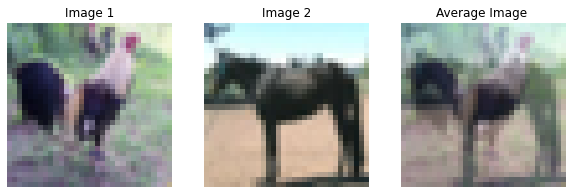

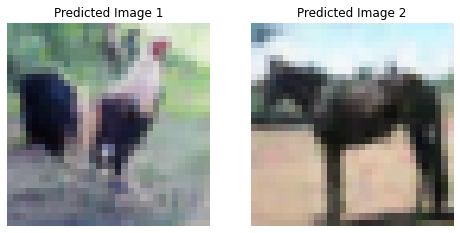

In [22]:
image_1, image_2, mean_image = get_random_pair(first_subset,second_subset)

test_model(unet,image_1, image_2, mean_image)

## Model Evaluation on testset

In [49]:
first_testsubset_idx = create_subset(test_dataset,[0,1,2,3,4],1000)
second_testsubset_idx = create_subset(test_dataset,[5,6,7,8,9],1000)

first_testsubset = Subset(dataset=test_dataset,indices=first_testsubset_idx)
second_testsubset = Subset(dataset=test_dataset,indices=second_testsubset_idx)

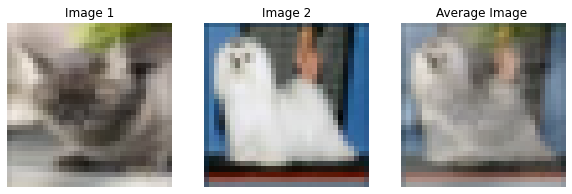

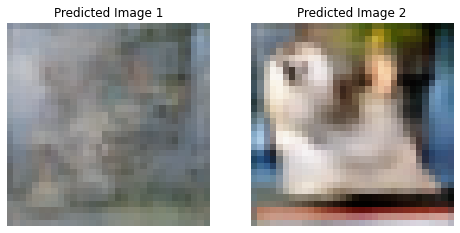

In [28]:
image_1, image_2, mean_image = get_random_pair(first_testsubset,second_testsubset)

test_model(unet,image_1, image_2, mean_image)

In [62]:
def compute_test_loss(model,test_dataset,criterion)-> float:
  """
  Compute loss on given test dataset
  """
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for x_1,x_2, mean_x in test_dataset:
      x_1 = x_1.to(device)
      x_2 = x_2.to(device)
      mean_x = mean_x.to(device)

      out1, out2 = model(mean_x)

      loss_1 = criterion(x_1,out1)
      loss_2 = criterion(x_2,out2)

      loss = loss_1 + loss_2

      test_loss += loss.item()

  return test_loss

In [61]:
custom_testdataset = CustomDataset(first_testsubset,second_testsubset)
custom_test_loader = DataLoader(dataset = custom_testdataset,batch_size = 32,shuffle = True,pin_memory=True)

test_loss = compute_test_loss(unet,custom_test_loader,criterion)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 25.7132
